In [1]:
# install the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
import spacy
nlp = spacy.load('en_core_web_sm')
import itertools
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Sentiment Analysi
from transformers import pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Unsupervised sentiment analysis with BERT

In [2]:
#import the dataset 
topic_tweets = pd.read_csv('topic_tweets.csv')

In [72]:
# rename the topics number with the actual names of the topics

topic_tweets["Topic"] = topic_tweets["Topic"].replace({0: "Finance", 1: "Sectors of involvement", 2:"Young entrepreneurs & education",
                                                      3: "Fintech & young talents", 4: "Internet usage & policies", 
                                                      5: "Guidance of starting a business", 6: "Accelerator programs"})

## 1.1 Some exploratory data analysis

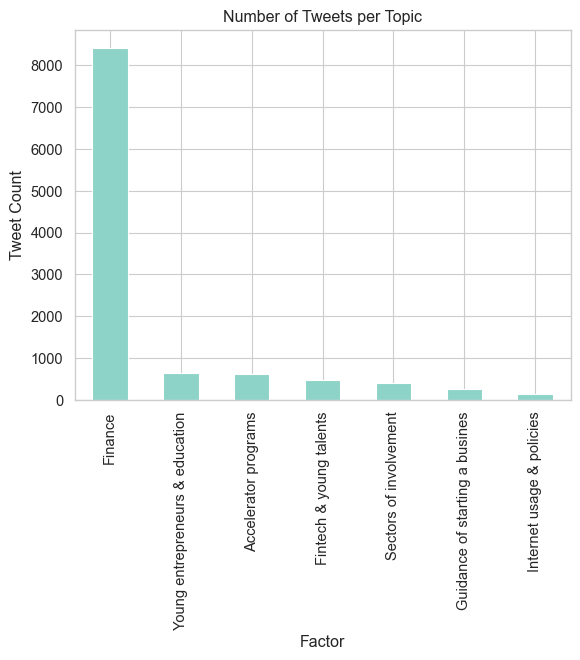

<Figure size 640x480 with 0 Axes>

In [76]:
tweet_counts = topic_tweets['Topic'].value_counts()
# Create a bar chart
ax = tweet_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Factor')
plt.ylabel('Tweet Count')
plt.title('Number of Tweets per Topic')

#ax.set_xticklabels(ax, rotation=90)
plt.show()

# Display the chart
plt.show()

# Save the chart as a PNG image
plt.savefig('bar_chart.png', bbox_inches='tight')

# Display the chart
plt.show()

## 1.2 Performing sentiment detection:
- by leveraging the pre-trained language model of BERT.
- more information can be found here: https://huggingface.co/learn/nlp-course/chapter1/3?fw=pt

In [137]:
# Downloading the sentiment analysis model
model =  pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [144]:
#create a function that access the sentiment labels and the score ranging from -1 to 1.

def BERTsentiment(inpText):
  result = model(inpText)
  label = result[0]['label']
  score = result[0]['score']
  if label == 'NEGATIVE':
    score = -score  # Multiply negative scores by -1
  return label, score

In [145]:
topic_tweets["Sentiment"], topic_tweets["Score"] = zip(*topic_tweets['Tweet'].apply(BERTsentiment))

In [9]:
#check for duplicates
topic_tweets.duplicated().sum()

0

In [8]:
#drop the duplicates
topic_tweets.drop_duplicates(inplace= True)

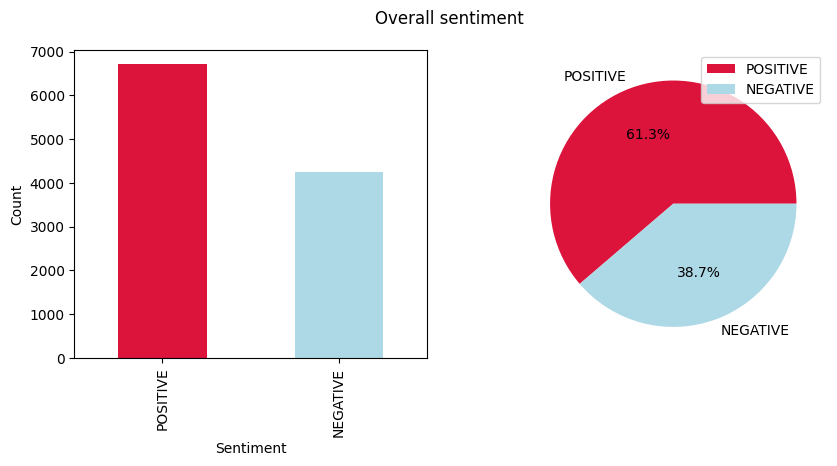

<Figure size 640x480 with 0 Axes>

In [12]:
# create visualization for the overall sentiment of the tweets

fig, subPlot = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Overall sentiment")

# Grouping the data
group_data = topic_tweets['Sentiment'].value_counts()

# Creating the charts
group_data.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
subPlot[0].set_ylabel('Count')


# Pie chart
group_data.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue'], autopct='%1.1f%%')

# Add percentage labels
subPlot[1].set_ylabel('')  # Remove the default 'Sentiment' label
subPlot[1].legend(labels=group_data.index, loc='upper right')

plt.show()
# Save the chart as plt.savefig('sentiment.png', bbox_inches='tight')a PNG image
plt.savefig('sentiment.png', bbox_inches='tight')
plt.show()

In [150]:
topic_tweets.to_csv('topic_tweets.csv', index= False)

In [61]:
pd.set_option("max_colwidth", None)

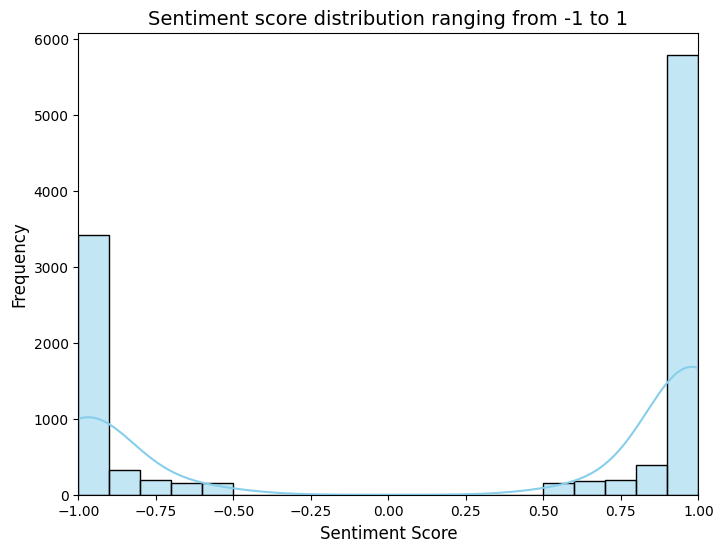

<Figure size 640x480 with 0 Axes>

In [16]:
# plot the sentiment distribution

import seaborn as sns
# Set the figure size
plt.figure(figsize=(8, 6))

# Create a distribution plot
sns.histplot(data=topic_tweets, x='Score', bins=20, kde=True, color='skyblue')

# Set the x-axis limits
plt.xlim(-1, 1)

# Set the labels and title
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Sentiment score distribution ranging from -1 to 1', fontsize=14)

# Show the plot
plt.show()
plt.savefig('sent_distrib.png', bbox_inches='tight')
plt.show()


In [89]:
len(topic_tweets)

10947

In [96]:
# compute the mean sentiment score for each topic
topic_tweets.groupby('Topic')['Score'].mean().sort_values(ascending=False).round(2)

Topic
Accelerator programs               0.40
Guidance of starting a busines     0.38
Internet usage & policies          0.34
Sectors of involvement             0.26
Fintech & young talents            0.25
Finance                            0.20
Young entrepreneurs & education    0.18
Name: Score, dtype: float64

## 1.3 Create pie charts of sentiment proportions of each topic

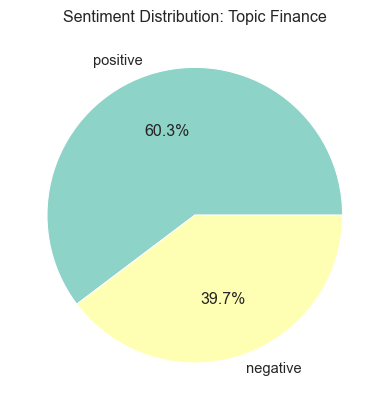

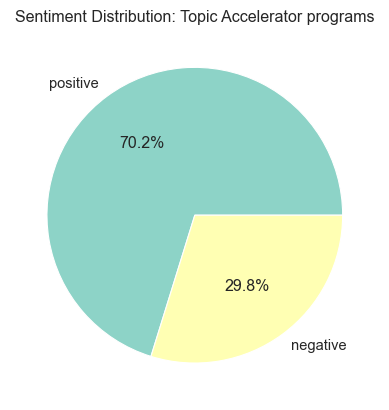

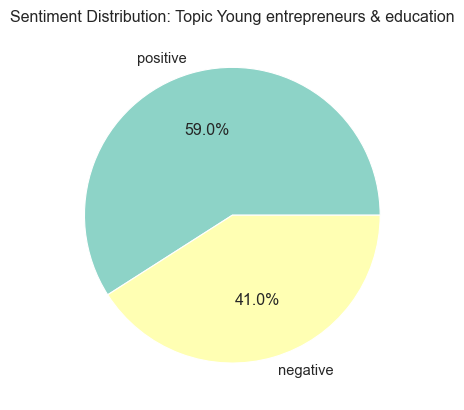

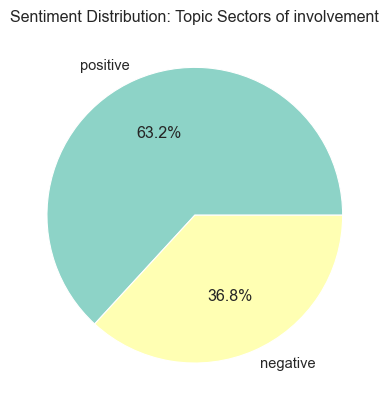

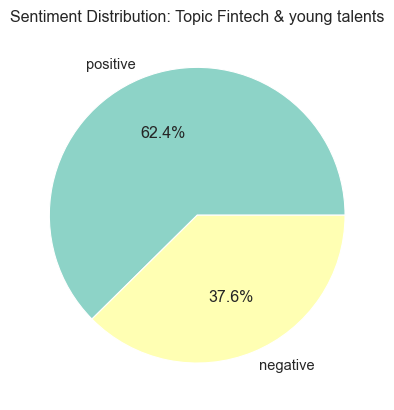

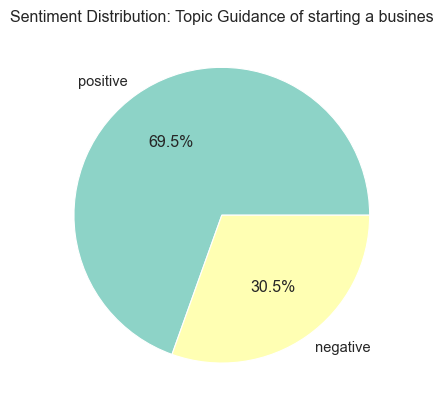

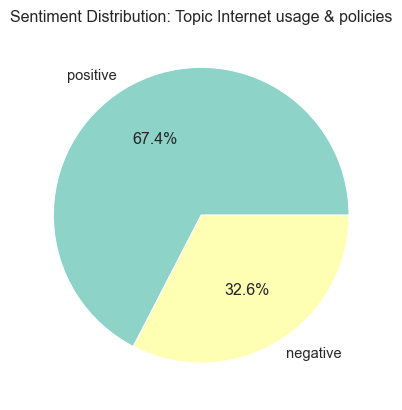

In [71]:
sentiment_percentages = []
sentiment_labels = ['positive', 'negative']
topics = topic_tweets['Topic'].unique()

for topic in topics:
    topic_df = topic_tweets[topic_tweets['Topic'] == topic]
    total_count = len(topic_df)
    
    positive_count = len(topic_df[topic_df["Sentiment"] == 'POSITIVE'])
    negative_count = len(topic_df[topic_df["Sentiment"] == 'NEGATIVE'])

    positive_percentage = positive_count / total_count * 100
    negative_percentage = negative_count / total_count * 100

    sentiment_percentages.append([positive_percentage, negative_percentage])

# Create a pie chart for each topic
for i, topic in enumerate(topics):
    sentiment_percentage = sentiment_percentages[i]
    topic_label = f'Topic {topic}'
    
    plt.figure()
    plt.pie(sentiment_percentage, labels=sentiment_labels, autopct='%1.1f%%')
    plt.title('Sentiment Distribution: ' + topic_label)
    plt.show()

## 1.4 Sentiment analysis overtime

## Merge two dataframes to one: 
- Our main goal is to access the created_at column from the original dataset with the "Sentiment" column (as created by BERT) based on the 'token_sentiment' column.
- In this way, we will access the date in which every tweet was posted.


In [77]:
start_ups = pd.read_csv('start.csv')

In [99]:
# Rename column 'Tweet' to 'token_sentiment' as it is in the original dataset. In this way, the token_sentiment column
#will be treated as a foreign key.

topic_tweets = topic_tweets.rename(columns={'Tweet': 'token_sentiment'})

In [100]:
start_ups = start_ups.drop_duplicates(subset='token_sentiment')
topic_tweets = topic_tweets.drop_duplicates(subset='token_sentiment')

In [101]:
merged_df = pd.merge(topic_tweets, start_ups, on='token_sentiment', how='left')

In [102]:
time_series = merged_df[['Score','Topic', 'created_at']]
time_series= time_series.drop_duplicates()

In [103]:
time_series['created_at'] = pd.to_datetime(time_series['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
time_series = time_series.dropna(subset=['created_at'])

In [130]:
time_series.dtypes

Score                float64
Topic                 object
created_at    datetime64[ns]
Year                   int32
dtype: object

In [105]:
# Extract the year from the 'created_at' column
time_series['Year'] = time_series['created_at'].dt.year

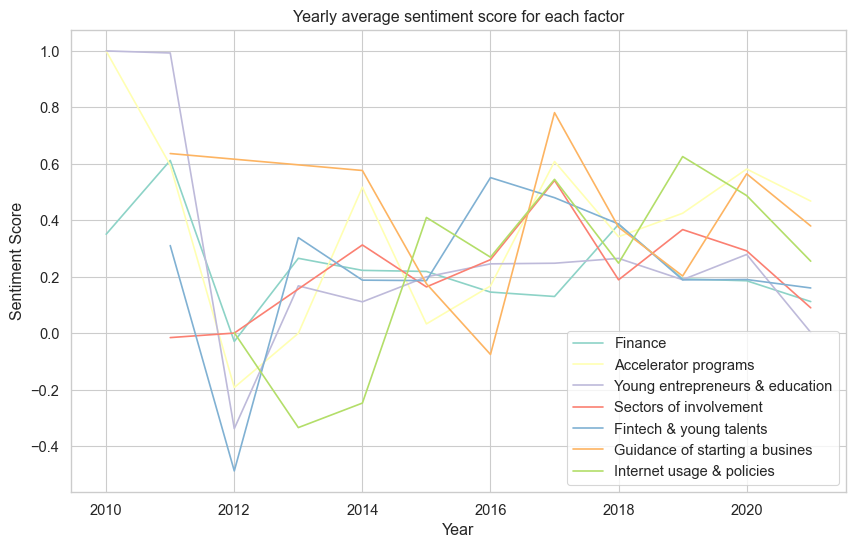

In [152]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Define a color palette with distinct colors
color_palette = sns.color_palette('Dark2', len(time_series['Topic'].unique()))

# Iterate over each topic
for topic in time_series['Topic'].unique():
    # Filter the data for the current topic
    topic_data = time_series[time_series['Topic'] == topic]

    # Group the data by year and calculate the mean sentiment score
    yearly_data = topic_data.groupby(time_series['Year'])['Score'].mean()

    # Plot the line for the current topic
    plt.plot(yearly_data.index, yearly_data.values, label=topic)

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Yearly average sentiment score for each factor')

# Add a legend
plt.legend()

# Show the plot
plt.show()